# VAE with convolutional layer and attention

![VAE + Conv1D encoder + Attention](img/vae_cnn1d_att_arch.png)

## Attention in Keras

Dot-product attention (Luong et al., 2015)

```python
    tf.keras.layers.Attention(use_scale=False, **kwargs)
```

$\large score(s_t, h_i) = s_t^TW_ah_i$

$\large score(s_t, h_i) = s_t^Th_i$


### Procedure

1. Dot product of query and value, that is $s_t^Th_i$ ->  `scores = tf.matmul(query, key, transpose_b=True)`
1. Softmax (weights), $\large \alpha_{t,i} = \frac{exp(score_{ti})}{\sum_{k=1}^{N}{exp(score_{tk})}}$ -> `distribution = tf.nn.softmax(scores)`
1. Weighted values using the output of softmax, $\alpha \cdot h$ -> `tf.matmul(distribution, value)`


In [1]:
# Data and dependencies
# VAE from https://blog.keras.io/building-autoencoders-in-keras.html

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Attention, Input, Dense, GRU, Reshape, Lambda, Conv1D, \
                                    GlobalAveragePooling1D, MaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras import backend as K # operations with tensors

import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalisation
x_train = x_train.astype('float32') / 255 # 255 max rgb value
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape(len(x_train), np.prod(x_train.shape[1:]))
x_test = x_test.reshape(len(x_test), np.prod(x_test.shape[1:]))

input_dim = x_train.shape[1]

# parameters
intermediate_dim = 32 # dimension of points in the latent space
batch_size = 128 
latent_dim = 2 # the two latent parameters z_mean and z_sigma

In [2]:
# architecture

inputs = Input(shape=(input_dim,), name='encoder_input')


# encoder (x -> z_mean & x -> z_log_var) A 'Y' shape
encoder_1 = Conv1D(filters=intermediate_dim, kernel_size=14, strides=7, padding='same')
encoder_out_1 = encoder_1(Reshape((input_dim,1))(inputs)) # B x timesteps (pixels) x features ([0,1])
maxpool = MaxPool1D(pool_size=2)
encoder_out_1 = maxpool(encoder_out_1)
encoder_2 = Conv1D(filters=intermediate_dim, kernel_size=2, padding='same')
encoder_out_2 =encoder_2(encoder_out_1)
encoder_out_2 = maxpool(encoder_out_2)

# attention
self_attention_out = Attention()([encoder_out_2, encoder_out_2])

self_attention_out = Reshape((K.prod(self_attention_out.shape[1:]),))(self_attention_out)
encoder_out_2 = Reshape((K.prod(encoder_out_2.shape[1:]),))(encoder_out_2)

from tensorflow.keras.layers import Concatenate
attention_out = Concatenate()([encoder_out_2, self_attention_out])

encoder_3 = Dense(intermediate_dim, activation='relu')
encoder_out_3 = encoder_3(attention_out)

z_mean = Dense(latent_dim, name='z_mean')
z_mean_out = z_mean(encoder_out_3)
z_log_sigma = Dense(latent_dim, name='z_log_sigma')
z_log_sigma_out = z_log_sigma(encoder_out_3)

In [3]:
# sampling
from tensorflow.keras import backend as K # operations with tensors

def sampling(params):
    z_mean, z_log_sigma = params
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim)) # mean = 0, std = 1
    return z_mean + K.exp(0.5 * z_log_sigma) * epsilon #

# We need to wrap the output of sampling into a layer for connecting it with the decoder. For that we can
# a Lambda layer
z = Lambda(sampling, output_shape=(latent_dim,))
z_out = z([z_mean_out, z_log_sigma_out])

In [4]:
# decoder
decoder_1 = Dense(intermediate_dim, activation='relu')
decoder_2 = Dense(input_dim, activation='sigmoid')
decoder_1_out = decoder_1(z_out)
decoder_2_out = decoder_2(decoder_1_out)

In [5]:
# models

# end-to-end autoencoder
vae = Model(inputs, decoder_2_out) 

# from inputs to latent space
encoder_model = Model(inputs, z_mean_out) 

# generator
decoder_input = Input(shape=(latent_dim, ))
#_decoder_1_out = decoder_1(decoder_input)
#_decoder_2_out = decoder_2(_decoder_1_out)
generator = Model(decoder_input, decoder_2(decoder_1(decoder_input)))
print(vae.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 784, 1)       0           encoder_input[0][0]              
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 112, 32)      480         reshape[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    multiple             0           conv1d[0][0]                     
                                                                 conv1d_1[0][0]               

In [6]:
# loss

# Reconstruction loss and KL divergence
def vae_loss(true, pred):
    l_re = binary_crossentropy(true, pred) * input_dim
    d_kl = - 0.5 * K.mean(1 + z_log_sigma_out - K.square(z_mean_out) - K.exp(z_log_sigma_out), axis=-1)

    loss = l_re + d_kl
    return loss

vae.compile(optimizer=Adadelta(learning_rate=1.0), loss=vae_loss, experimental_run_tf_function=False)


In [7]:
# train 
vae.fit(x_train, x_train,
       shuffle=True,
       epochs=20,
       batch_size=batch_size,
       validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 22s 366us/sample - loss: 207.3708 - val_loss: 180.6279
Epoch 2/20
60000/60000 [==============================] - 21s 349us/sample - loss: 174.9874 - val_loss: 169.8693
Epoch 3/20
60000/60000 [==============================] - 23s 391us/sample - loss: 169.4104 - val_loss: 166.9121
Epoch 4/20
60000/60000 [==============================] - 18s 297us/sample - loss: 166.6352 - val_loss: 164.9191
Epoch 5/20
60000/60000 [==============================] - 22s 370us/sample - loss: 164.5476 - val_loss: 163.5465
Epoch 6/20
60000/60000 [==============================] - 22s 369us/sample - loss: 163.2045 - val_loss: 163.3893
Epoch 7/20
60000/60000 [==============================] - 22s 365us/sample - loss: 162.2453 - val_loss: 161.6911
Epoch 8/20
60000/60000 [==============================] - 24s 392us/sample - loss: 161.4288 - val_loss: 161.0830
Epoch 9/20
60000/60000 [======================

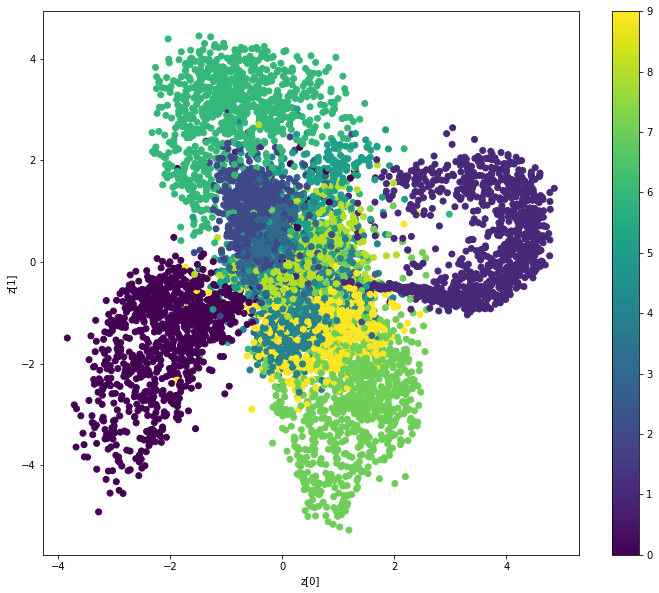

In [8]:
x_test_encoded = encoder_model.predict(x_test, batch_size=batch_size)

# distributions of the different classes
plt.figure(figsize=(12, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

In [9]:
# display generator usin random values within the interval
# shown by the encoder [-4,4]
def generate_digits(n):
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))

    # we will sample n points within [-4, 4] standard deviations
    grid_x = np.linspace(-4, 4, n) # value obtain with the encoder
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = generator.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))

    # axis labels 
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1

    pixel_range = np.arange(start_range, end_range, digit_size)

    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)

    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")

    plt.imshow(figure)
    plt.show()

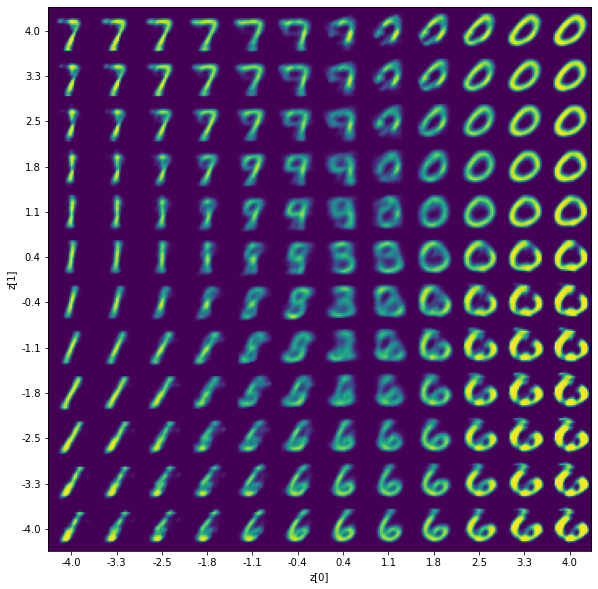

In [10]:
generate_digits(12)

In [11]:
# show images
import matplotlib.pyplot as plt

def see_images(dataset, n):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(dataset[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

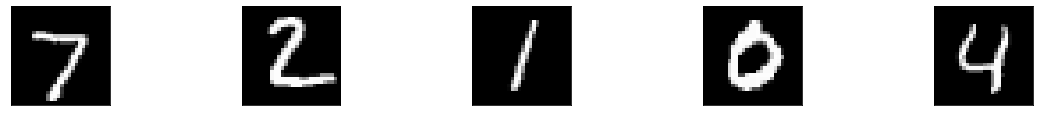

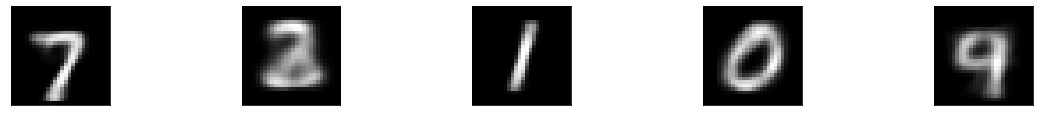

In [12]:
prediction = vae.predict(x_test)

# Visualisation of predictions
see_images(x_test, 5)
see_images(prediction, 5)